## 1. Load and summarize cis-variance predictions from FlashZoi

First we'll compare the two gene sets to understand their different characteristics:


In [25]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")


clingen_scored_dir = "/Users/markus/seq2expr-variance/data/output/dataset3/flashzoi_outputs/ClinGen_gene_curation_list"
nonessential_scored_dir = "/Users/markus/seq2expr-variance/data/output/dataset3/flashzoi_outputs/nonessential_ensg"

clingen_cache = "/Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/clingen_summary_corrected_tracks.tsv"
nonessential_cache = "/Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/nonessential_summary_corrected_track.tsv"

gtex_expr_file = "../data/initial/GTEx_Analysis_2022-06-06_v10_RNASeQCv2.4.2_gene_median_tpm.gct"

gene_metrics_vgh = "/Users/markus/seq2expr-variance/data/initial/gene_metrics_vgh_202407.tsv.gz"

gtex_eql_data = "/Users/markus/seq2expr-variance/data/intermediate/eQTL_v10"

In [26]:
def load_variants_summary(
        variants_scored_dir: str,
        cache_file: str,
        min_af: float = 0.01,
        force_reload: bool = False
    ) -> pd.DataFrame:
    """
    Build a per-gene summary table from scored-variant folders.
    variants_scored_dir : str
        Path containing one sub-folder per gene, each with <gene>_variants.tsv.
    cache_file : str
        Where the summary TSV will be cached / read from.
    min_af : float, optional
        Minimum alternate-allele frequency (inclusive) to keep a variant. Filtering the common variants here
    force_reload : bool, optional
        Ignore an existing cache and rebuild the summary
    """
    if os.path.exists(cache_file) and not force_reload:
        var_df = pd.read_csv(cache_file, sep="\t")
        print(f"Loaded cached gene summary table: {cache_file}")
        return var_df

    records = []
    for folder in glob.glob(os.path.join(variants_scored_dir, "*")):
        gene_id  = os.path.basename(folder)
        var_file = os.path.join(folder, f"{gene_id}_variants.tsv")
        if not os.path.isfile(var_file):
            continue

        df = pd.read_csv(var_file, sep="\t")
        df.columns = df.columns.str.upper()

        if "AF" not in df.columns:
            continue  # skip malformed tables
        df["AF"] = pd.to_numeric(df["AF"], errors="coerce")
        before = len(df)
        df = df[df["AF"] >= min_af].reset_index(drop=True)
        after = len(df)
        # Uncomment for debugging:
        # print(f"{gene_id}: kept {after}/{before} variants with AF ≥ {min_af}")

        if df.empty or not {"VAR_I", "DELTA"}.issubset(df.columns):
            continue

        up_mask   = df["DELTA"] >  0
        down_mask = df["DELTA"] <  0

        records.append({
            "gene_id": gene_id,
            "predicted_cis_variance": df["VAR_I"].sum(),
            "num_snps": len(df),
            "mean_AF": df["AF"].mean(),
            "median_AF": df["AF"].median(),
            "mean_DELTA": df["DELTA"].mean(),
            "median_DELTA": df["DELTA"].median(),
            "mean_VAR_I": df["VAR_I"].mean(),
            "median_VAR_I": df["VAR_I"].median(),
            "predicted_cis_variance_up"   : df.loc[up_mask,   "VAR_I"].sum(),
            "predicted_cis_variance_down" : df.loc[down_mask, "VAR_I"].sum(),
            "num_snps_up"                 : up_mask.sum(),
            "num_snps_down"               : down_mask.sum(),
        })

    var_df = pd.DataFrame(records)
    var_df.to_csv(cache_file, sep="\t", index=False)
    print(f"Saved gene summary to: {cache_file}")
    return var_df

var_df_clingen = load_variants_summary(clingen_scored_dir, clingen_cache,
                                       min_af=0.01, force_reload=True)
var_df_nonessential = load_variants_summary(nonessential_scored_dir, nonessential_cache,
                                            min_af=0.01, force_reload=True)

print("ClinGen:", var_df_clingen.shape)
print(var_df_clingen.head())
print("Non-essential:", var_df_nonessential.shape)
print(var_df_nonessential.head())

sns.set_theme(style="whitegrid")

var_df_clingen      = var_df_clingen.copy()
var_df_nonessential = var_df_nonessential.copy()
var_df_clingen["cohort"]      = "ClinGen"
var_df_nonessential["cohort"] = "Non-essential"
var_df_all = pd.concat([var_df_clingen, var_df_nonessential], ignore_index=True)
var_df_all["cohort"] = "Combined"

cohort_dfs = {
    "ClinGen"        : var_df_clingen,
    "Non-essential"  : var_df_nonessential,
    "Combined"       : var_df_all
}


Saved gene summary to: /Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/clingen_summary_corrected_tracks.tsv
Saved gene summary to: /Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/nonessential_summary_corrected_track.tsv
ClinGen: (314, 13)
           gene_id  predicted_cis_variance  num_snps   mean_AF  median_AF  \
0  ENSG00000015171            5.192293e-07      1993  0.224439   0.083773   
1  ENSG00000089225            8.054877e-07      2875  0.176341   0.078200   
2  ENSG00000182774            3.950705e-04      2685  0.164024   0.065789   
3  ENSG00000096696            1.180269e-04      2848  0.216798   0.123680   
4  ENSG00000179348            5.482736e-07      2364  0.198366   0.053371   

     mean_DELTA  median_DELTA    mean_VAR_I  median_VAR_I  \
0 -7.799352e-07  0.000000e+00  2.605265e-10  9.501787e-13   
1 -3.529641e-06 -7.059425e-07  2.801696e-10  1.369285e-12   
2  9.653000e-05  4.816055e-05  1.471399e-07  9.763669e-10   
3 -3.176069e-05 -3.3

In [20]:
import pandas as pd

tissue_files = {
    "blood": "../../data/intermediate/eQTL_v10/GTEx_Analysis_v10_eQTL_updated/Whole_Blood.v10.eGenes.txt.gz",
    "esophagus": "../../data/intermediate/eQTL_v10/GTEx_Analysis_v10_eQTL_updated/Esophagus_Mucosa.v10.eGenes.txt.gz",
    "muscle": "../../data/intermediate/eQTL_v10/GTEx_Analysis_v10_eQTL_updated/Muscle_Skeletal.v10.eGenes.txt.gz",
    "brain": "../../data/intermediate/eQTL_v10/GTEx_Analysis_v10_eQTL_updated/Brain_Frontal_Cortex_BA9.v10.eGenes.txt.gz",
    "liver": "../../data/intermediate/eQTL_v10/GTEx_Analysis_v10_eQTL_updated/Liver.v10.eGenes.txt.gz"
}

def load_tissue_eqtl(file, tissue):
    df = pd.read_csv(file, sep="\t", compression="gzip")
    df["gene_id"] = df["gene_id"].astype(str).str.split(".").str[0]  # clean version suffix
    df["tissue"] = tissue
    return df[["gene_id", "afc", "qval", "pval_perm", "num_var", "tissue"]]

eqtl_all = pd.concat(
    [load_tissue_eqtl(f, t) for t, f in tissue_files.items()],
    ignore_index=True
)

print(eqtl_all.head())

agg_eqtl = (
    eqtl_all
    .groupby("gene_id")
    .agg(
        mean_afc=("afc", "mean"),
        median_qval=("qval", "median"),
        min_qval=("qval", "min"),
        tissues_with_qval05=("qval", lambda x: (x < 0.05).sum()),
        total_tissues=("tissue", "nunique"),
        mean_num_var=("num_var", "mean")
    )
    .reset_index()
)

var_df_clingen["gene_id"] = var_df_clingen["gene_id"].astype(str).str.split(".").str[0]
var_df_nonessential["gene_id"] = var_df_nonessential["gene_id"].astype(str).str.split(".").str[0]

merged_clingen = pd.merge(var_df_clingen, agg_eqtl, on="gene_id", how="inner")
merged_nonessential = pd.merge(var_df_nonessential, agg_eqtl, on="gene_id", how="inner")

print("ClinGen:", merged_clingen.shape)
print(merged_clingen.head(15))
print("Non-essential:", merged_nonessential.shape)
print(merged_nonessential.head(15))

           gene_id       afc          qval  pval_perm  num_var tissue
0  ENSG00000227232  0.703251  1.036430e-07     0.0001     1357  blood
1  ENSG00000238009  2.294418  4.333870e-26     0.0001     1798  blood
2  ENSG00000233750  1.248612  1.998920e-08     0.0001     1816  blood
3  ENSG00000268903  0.941367  5.744450e-12     0.0001     1857  blood
4  ENSG00000269981  1.389733  5.829050e-25     0.0001     1861  blood
ClinGen: (311, 20)
            gene_id  predicted_cis_variance  num_snps   mean_AF  median_AF  \
0   ENSG00000015171            5.192293e-07      1993  0.224439   0.083773   
1   ENSG00000089225            8.054877e-07      2875  0.176341   0.078200   
2   ENSG00000182774            3.950705e-04      2685  0.164024   0.065789   
3   ENSG00000096696            1.180269e-04      2848  0.216798   0.123680   
4   ENSG00000179348            5.482736e-07      2364  0.198366   0.053371   
5   ENSG00000117595            1.085384e-05      2191  0.201626   0.088805   
6   ENSG0000010

## 1. Exploring single gene

In [27]:
_SCORED_FOLDERS = {
    "ClinGen"       : clingen_scored_dir,
    "Non-essential" : nonessential_scored_dir,
}

def _pick_id(df, fallback_cols=("CHR", "POS")):
    for cand in ("RSID", "ID", "SNP", "VAR_ID"):
        if cand in df.columns:
            return cand
    if all(col in df.columns for col in fallback_cols):
        return fallback_cols
    return None  # will use df.index later

def plot_gene_variants(
        gene_id: str,
        cohort : str,
        top_n  : int = 3,
        label_cols: tuple | list | None = None):

    fpath = Path(_SCORED_FOLDERS[cohort]) / gene_id / f"{gene_id}_variants.tsv"
    if not fpath.exists():
        print(f"Variant file not found: {fpath}")
        return

    df = pd.read_csv(fpath, sep="\t")
    df.columns = df.columns.str.upper()
    if df.empty or {"VAR_I", "DELTA"}.difference(df.columns):
        print("Table lacks VAR_I or DELTA.")
        return

    df["direction"] = np.where(df["DELTA"] > 0, "Up", "Down")
    df["AF"] = pd.to_numeric(df["AF"], errors="coerce")
    df["log_VAR_I"] = np.log10(df["VAR_I"] + 1e-20)

    id_key = label_cols or _pick_id(df)
    def _lab(row):
        if id_key is None:
            return f"idx {row.name}"
        if isinstance(id_key, str):
            return str(row[id_key])
        return f"{row[id_key[0]]}:{row[id_key[1]]}"

    df_top = df.nlargest(top_n, "VAR_I").copy()
    df_top["label"] = df_top.apply(_lab, axis=1)

    up_sum   = df.loc[df["direction"] == "Up",   "VAR_I"].sum()
    down_sum = df.loc[df["direction"] == "Down", "VAR_I"].sum()
    total_sum = up_sum + down_sum

    cohort_df = var_df_clingen if cohort == "ClinGen" else var_df_nonessential
    total_rank = cohort_df["predicted_cis_variance"].rank(ascending=False, method="min")
    ratio = cohort_df["predicted_cis_variance_up"] / cohort_df["predicted_cis_variance_down"].replace(0, np.nan)
    ratio_rank = ratio.rank(ascending=False, method="min")
    r_tot  = (total_rank[cohort_df["gene_id"] == gene_id])
    r_ud   = (ratio_rank[cohort_df["gene_id"] == gene_id])
    n_genes = len(cohort_df)

    eqtl_row = agg_eqtl[agg_eqtl["gene_id"] == gene_id]
    eqtl_summary = ""
    if not eqtl_row.empty:
        row = eqtl_row.iloc[0]
        eqtl_summary = (
            f"GTEx eQTLs:\n"
            f"mean AFC = {row['mean_afc']:.2f}\n"
            f"min q    = {row['min_qval']:.1e}\n"
            f"sig tissues = {row['tissues_with_qval05']}/{row['total_tissues']}"
        )
    else:
        eqtl_summary = "GTEx eQTLs:\nno data"

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 4, figsize=(18, 4))

    # Panel 1 — Variant scatterplot
    df["log_DELTA"] = np.sign(df["DELTA"]) * np.log10(np.abs(df["DELTA"]) + 1e-8)
    sns.scatterplot(df, x="AF", y="DELTA", size="log_VAR_I",
                    hue="direction", palette={"Up": "steelblue", "Down": "orangered"},
                    sizes=(30, 300), alpha=.6, ax=ax[0], legend=False)
    ymax = np.nanmax(np.abs(df["DELTA"])) * 1.05
    ax[0].set_ylim(-ymax, ymax)
    ax[0].axhline(0, color='grey', lw=.8)
    ax[0].set_xscale("log")
    ax[0].set_xlabel("Allele frequency (proportion, log scale)")
    ax[0].set_ylabel("Δ predicted expression (log TPM)")
    ax[0].set_title("Variant-level effects")

    for _, row in df_top.iterrows():
        txt = (f"{row['label']}\nAF={row['AF']:.2f}\nΔ={row['DELTA']:.2e}")
        ax[0].annotate(txt, xy=(row["AF"], row["DELTA"]),
                       xytext=(5, 5), textcoords="offset points",
                       fontsize=7,
                       arrowprops=dict(arrowstyle='-', lw=0.5, color='black'))

    # Panel 2 — Pie chart of variance direction
    sizes = [up_sum, down_sum]
    labels = ["Up", "Down"]
    colors = ["steelblue", "orangered"]
    def autopct(pct):
        val = pct / 100. * total_sum
        return f"{pct:.1f}%\n({val:.1e})"

    ax[1].pie(sizes, labels=labels, colors=colors, autopct=autopct,
              startangle=90, counterclock=False)
    ax[1].axis("equal")
    ax[1].set_title("Predicted cis-variance split (log TPM²)")

    ax[1].text(1.2, 0.2, eqtl_summary,
               transform=ax[1].transAxes,
               fontsize=9, verticalalignment='top')

    # Panel 3 — Histogram of VAR_I
    sns.histplot(df["VAR_I"], bins=40, log_scale=True, color="grey", ax=ax[2])
    ax[2].set_xlabel("VAR_I (log10, log TPM²)")
    ax[2].set_ylabel("Variant count")
    ax[2].set_title("Variant-level variance distribution")

    # Panel 4 — Cumulative variance
    df_sorted = df.sort_values("VAR_I", ascending=False).reset_index(drop=True)
    cum_frac = df_sorted["VAR_I"].cumsum() / total_sum
    ax[3].plot(cum_frac, marker=".", lw=1.5)
    ax[3].axhline(.95, ls="--", color="red")
    ax[3].axvline(top_n - 1, ls="--", color="grey")
    ax[3].set_ylim(0, 1.05)
    ax[3].set_xlabel("Variant rank (by VAR_I)")
    ax[3].set_ylabel("Cumulative fraction of cis-variance")
    ax[3].set_title("Concentration of expression variance")

    # Overall figure title
    fig.suptitle(f"{gene_id} - {cohort}\n"
                 f"rank ΣVAR_I {r_tot.iloc[0]}/{n_genes}   "
                 f"rank Up/Down ratio {r_ud.iloc[0]}/{n_genes}",
                 fontsize=13, weight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.88])

    save_root = Path("/Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/single_gene")
    subfolder = "clingen" if cohort.lower().startswith("clingen") else "non_essential"
    out_dir = save_root / subfolder
    out_dir.mkdir(parents=True, exist_ok=True)
    plt.show()
    fig.savefig(out_dir / f"{gene_id}_dashboard.png", dpi=300)

    # Console printout
    print(f"{gene_id}  ({cohort})")
    print(f"variants: {len(df)}   up: {sum(df['direction']=='Up')}   down: {sum(df['direction']=='Down')}")
    print(f"Σ VAR_I up   = {up_sum:.2e}")
    print(f"Σ VAR_I down = {down_sum:.2e}")
    if total_sum: print(f"Up fraction  = {up_sum/total_sum:.2%}")
    print(f"rank ΣVAR_I  = {r_tot.iloc[0]}/{n_genes}")
    print(f"rank Up/Down = {r_ud.iloc[0]}/{n_genes}")
    print(eqtl_summary.replace("\n", " | "))


## 1.1 Clingen cohort

### 1.2 Top 5 genes in ClinGen cohort by total predicted cis-variance (ΣVAR_I)

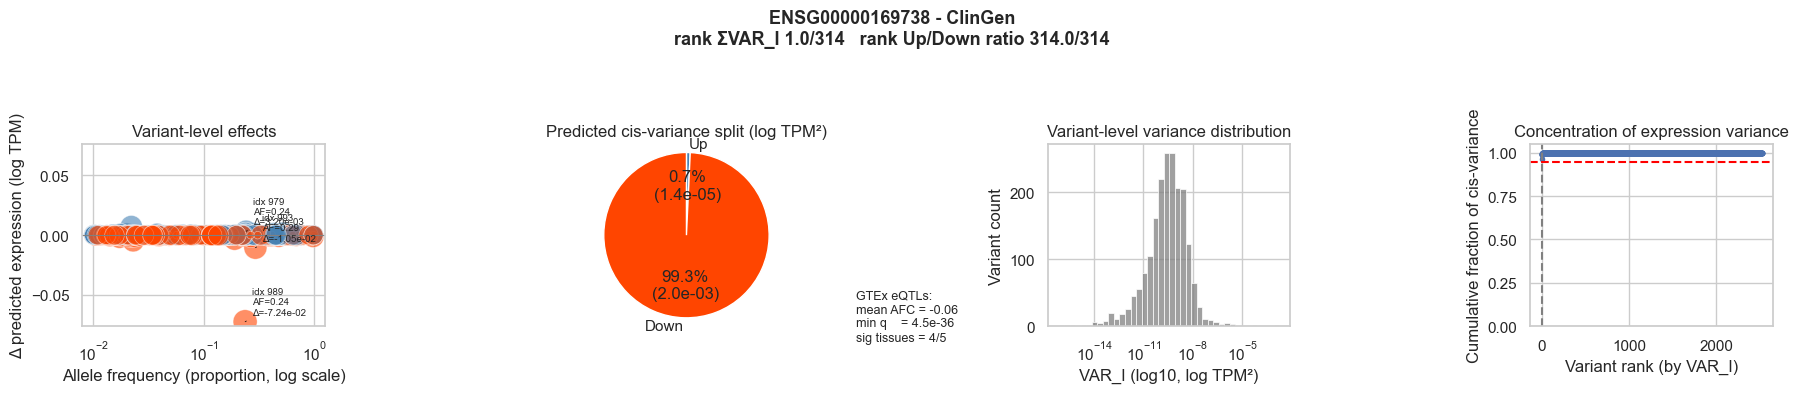

ENSG00000169738  (ClinGen)
variants: 2523   up: 1063   down: 1460
Σ VAR_I up   = 1.44e-05
Σ VAR_I down = 1.95e-03
Up fraction  = 0.73%
rank ΣVAR_I  = 1.0/314
rank Up/Down = 314.0/314
GTEx eQTLs: | mean AFC = -0.06 | min q    = 4.5e-36 | sig tissues = 4/5


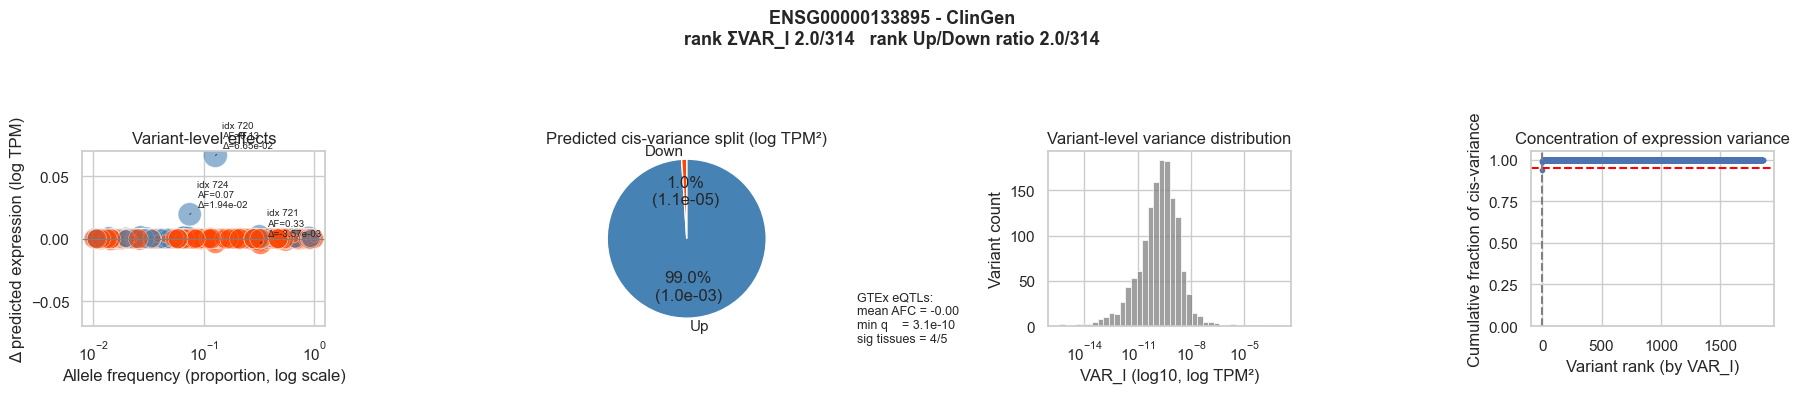

ENSG00000133895  (ClinGen)
variants: 1860   up: 469   down: 1391
Σ VAR_I up   = 1.04e-03
Σ VAR_I down = 1.07e-05
Up fraction  = 98.98%
rank ΣVAR_I  = 2.0/314
rank Up/Down = 2.0/314
GTEx eQTLs: | mean AFC = -0.00 | min q    = 3.1e-10 | sig tissues = 4/5


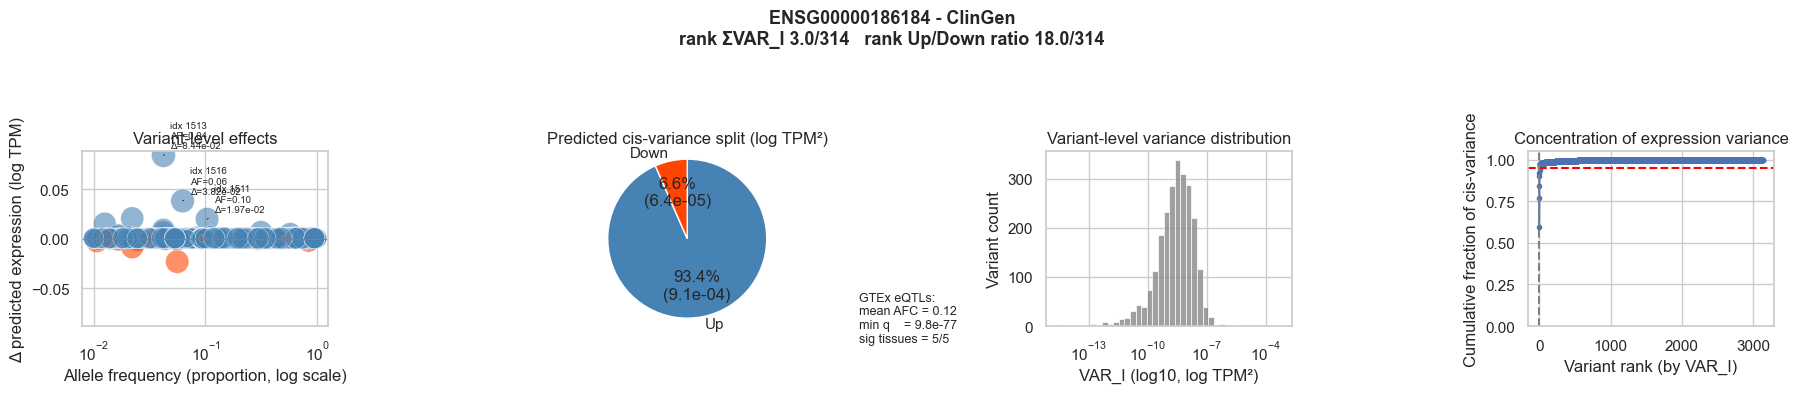

ENSG00000186184  (ClinGen)
variants: 3134   up: 2241   down: 893
Σ VAR_I up   = 9.09e-04
Σ VAR_I down = 6.38e-05
Up fraction  = 93.44%
rank ΣVAR_I  = 3.0/314
rank Up/Down = 18.0/314
GTEx eQTLs: | mean AFC = 0.12 | min q    = 9.8e-77 | sig tissues = 5/5


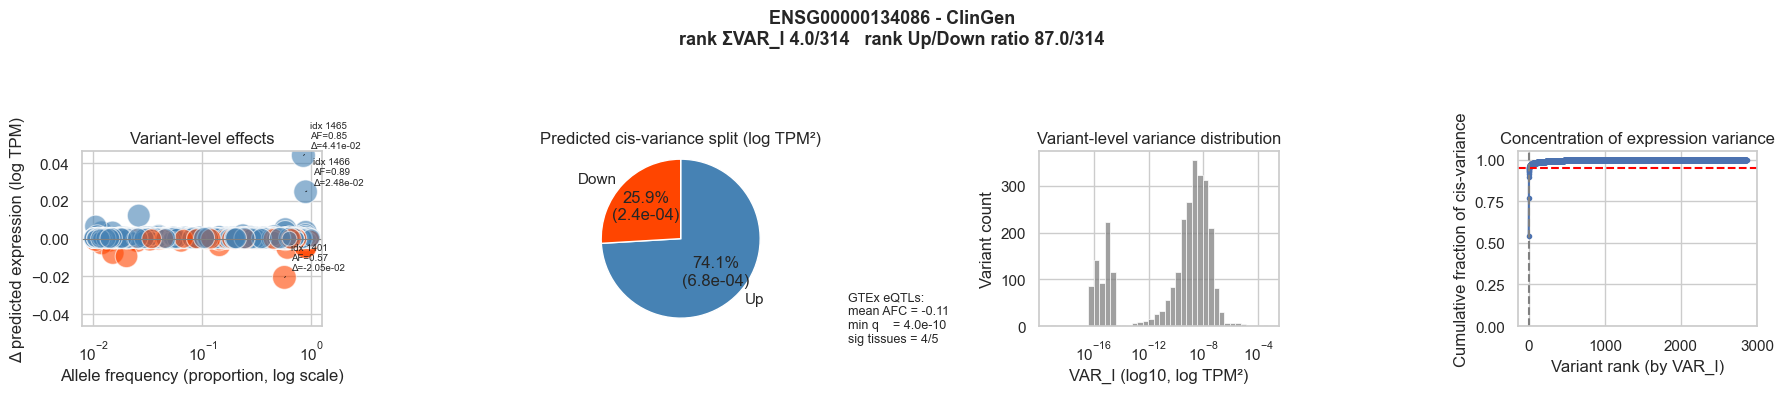

ENSG00000134086  (ClinGen)
variants: 2862   up: 2522   down: 340
Σ VAR_I up   = 6.81e-04
Σ VAR_I down = 2.39e-04
Up fraction  = 74.06%
rank ΣVAR_I  = 4.0/314
rank Up/Down = 87.0/314
GTEx eQTLs: | mean AFC = -0.11 | min q    = 4.0e-10 | sig tissues = 4/5


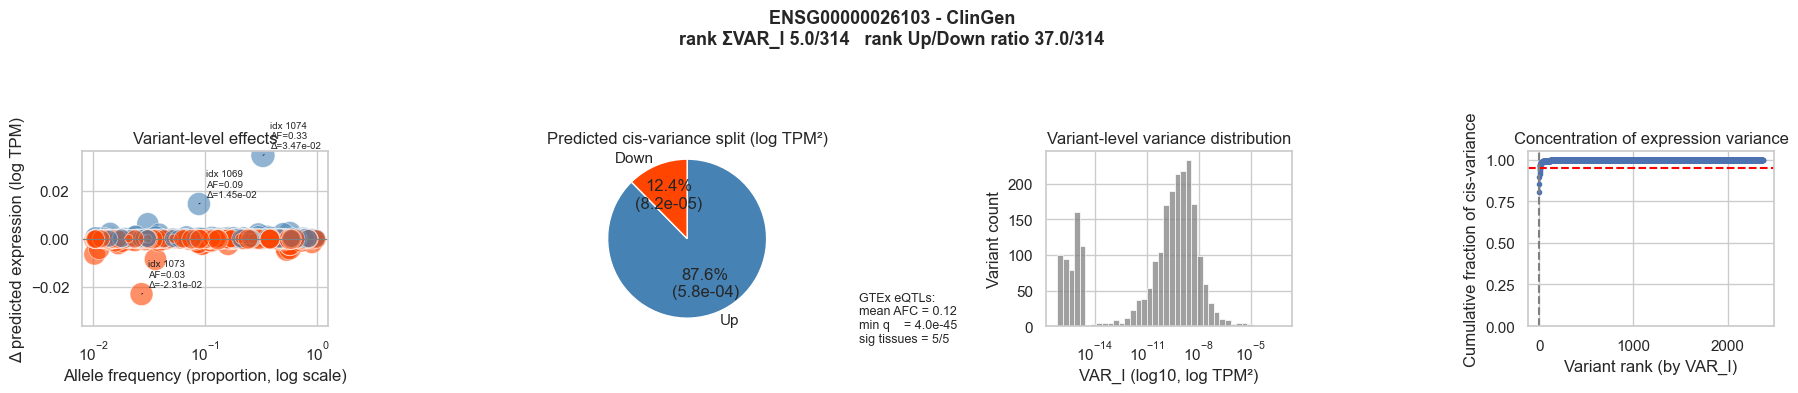

ENSG00000026103  (ClinGen)
variants: 2375   up: 733   down: 1642
Σ VAR_I up   = 5.79e-04
Σ VAR_I down = 8.16e-05
Up fraction  = 87.64%
rank ΣVAR_I  = 5.0/314
rank Up/Down = 37.0/314
GTEx eQTLs: | mean AFC = 0.12 | min q    = 4.0e-45 | sig tissues = 5/5


In [28]:
top_by_var = (
    var_df_clingen.sort_values("predicted_cis_variance", ascending=False)
                  .head(5)["gene_id"]
)

for g in top_by_var:
    plot_gene_variants(g, cohort="ClinGen")


ClinGen genes with the strongest predicted cis-variance signals from the FlashZoi model. All show highly skewed contributions from a small number of variants, indicating focused regulatory impact


### 1. ENSG00000169738
- Direction: 99% of variance from down-regulating variants.
- Variants: 2523 total (1063 up, 1460 down)
- SUM VAR_I: down = 1.95e-03, up = 1.44e-05
- Takeaway: This gene likely contains a few strong, common variants that *reduce* expression. Suggestive of loss-of-function sensitivity.
- Rank: 153 / 314


### 2. ENSG00000133895
- Direction: ~99% of variance from up-regulating variants.
- Variants: 1860 total (469 up, 1391 down)
- SUM VAR_I: up = 1.04e-03, down = 1.07e-05
- Takeaway: Most expression-altering variants are mild, but a few *increase* expression significantly. Possible gain-of-function sensitivity.
- Rank: 116 / 314


### 3. ENSG00000186184
- Direction: 93% of variance from up-regulating variants.
- Variants: 3134 total (2241 up, 893 down)
- SUM VAR_I: up = 9.09e-04, down = 6.38e-05
- Takeaway: Very high overall variance. Indicates strong, focused up-regulation effects in muscle tissue.
- Rank: 10 / 314 (top-ranked)


### 4. ENSG00000134086
- Direction: 74% of variance from up-regulating variants.
- Variants: 2862 total (2522 up, 340 down)
- SUM VAR_I: up = 6.81e-04, down = 2.39e-04
- Takeaway: Moderate total variance but extremely skewed directionality (Up/Down ratio = 87). Suggests regulatory pressure to increase expression.
- Rank: 113 / 314

---
Cis-regulatory variance is not evenly distributed. A few common SNPs with large predicted effects dominate each gene’s signal.
As we know from previous analysis that effect size—not SNP count—drives predicted cis-variance

### 1.1.2 The most extreme up–down imbalance

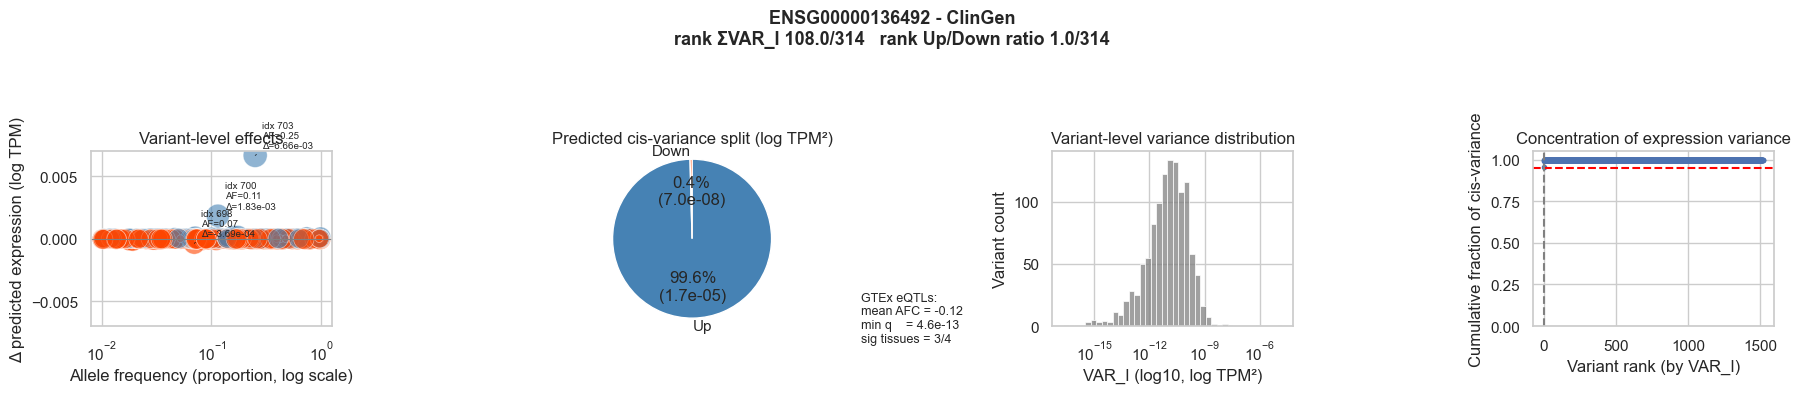

ENSG00000136492  (ClinGen)
variants: 1522   up: 464   down: 1058
Σ VAR_I up   = 1.74e-05
Σ VAR_I down = 6.99e-08
Up fraction  = 99.60%
rank ΣVAR_I  = 108.0/314
rank Up/Down = 1.0/314
GTEx eQTLs: | mean AFC = -0.12 | min q    = 4.6e-13 | sig tissues = 3/4


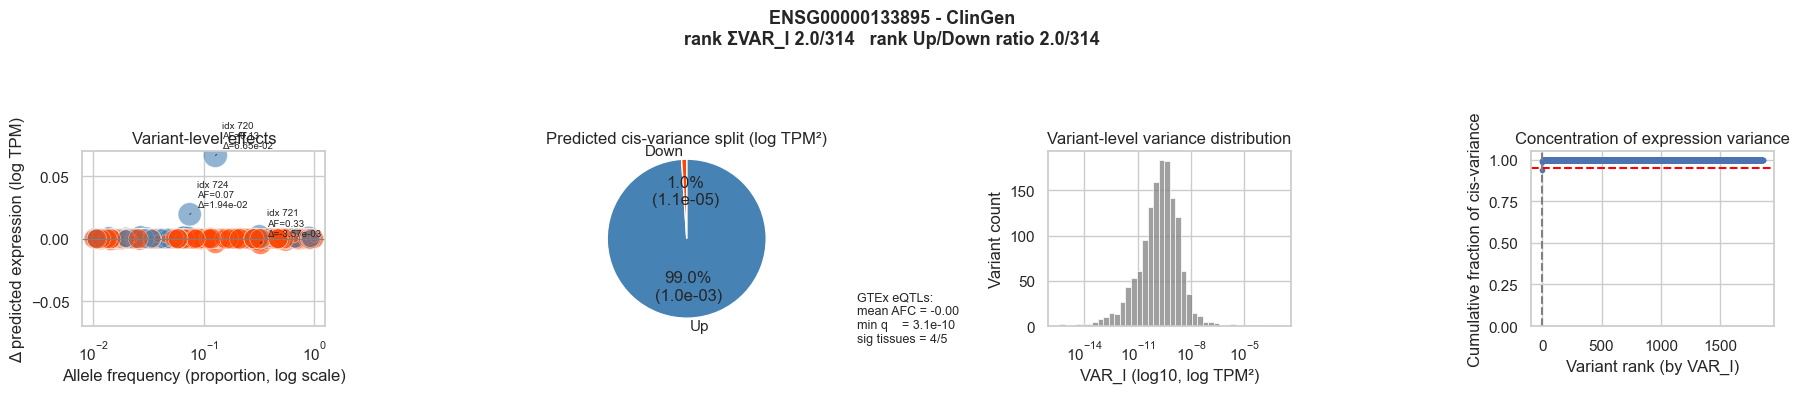

ENSG00000133895  (ClinGen)
variants: 1860   up: 469   down: 1391
Σ VAR_I up   = 1.04e-03
Σ VAR_I down = 1.07e-05
Up fraction  = 98.98%
rank ΣVAR_I  = 2.0/314
rank Up/Down = 2.0/314
GTEx eQTLs: | mean AFC = -0.00 | min q    = 3.1e-10 | sig tissues = 4/5


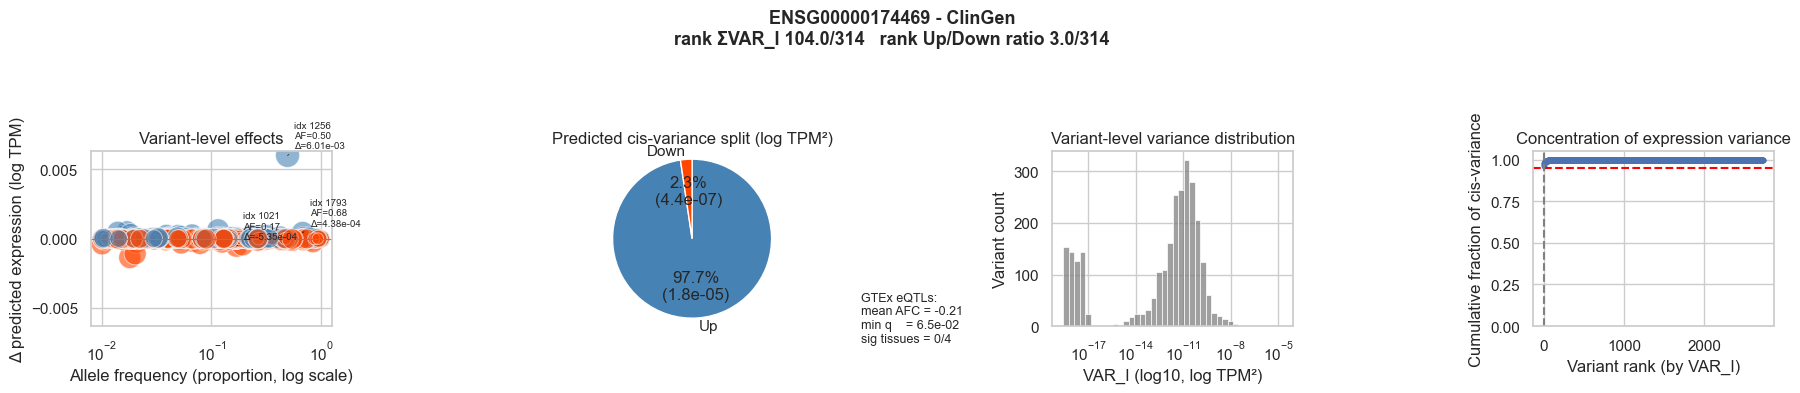

ENSG00000174469  (ClinGen)
variants: 2729   up: 987   down: 1742
Σ VAR_I up   = 1.84e-05
Σ VAR_I down = 4.41e-07
Up fraction  = 97.66%
rank ΣVAR_I  = 104.0/314
rank Up/Down = 3.0/314
GTEx eQTLs: | mean AFC = -0.21 | min q    = 6.5e-02 | sig tissues = 0/4


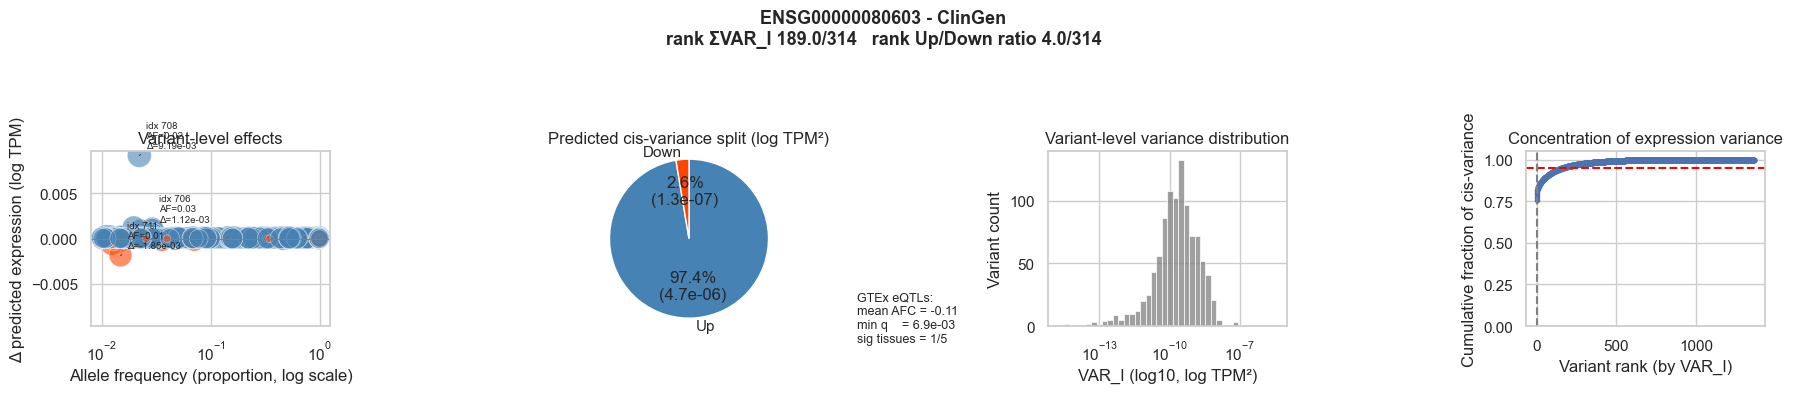

ENSG00000080603  (ClinGen)
variants: 1369   up: 935   down: 434
Σ VAR_I up   = 4.70e-06
Σ VAR_I down = 1.27e-07
Up fraction  = 97.37%
rank ΣVAR_I  = 189.0/314
rank Up/Down = 4.0/314
GTEx eQTLs: | mean AFC = -0.11 | min q    = 6.9e-03 | sig tissues = 1/5


In [29]:
for df in (var_df_clingen, var_df_nonessential):
    df["up_down_ratio"] = (
        df["predicted_cis_variance_up"] /
        df["predicted_cis_variance_down"].replace(0, np.nan)
    )

extreme_ratio = (
    var_df_clingen.sort_values("up_down_ratio", ascending=False)
                  .head(4)["gene_id"]
)

for g in extreme_ratio:
    plot_gene_variants(g, cohort="ClinGen")


These genes show extreme skew toward up-regulating variants, but only some show strong total variance

### 1. ENSG00000136492
- Direction: 99.6% of variance from up-regulating variants.
- Variants: 1522 total (464 up, 1058 down)
- SUM VAR_I: up = 1.74e-05, down = 6.99e-08
- Rank: 294 / 314 (very low total variance)
- Takeaway: Despite extreme up/down imbalance, the total variance is low—likely not functionally impactful.


### 2. ENSG00000133895 _(repeated from earlier)_
- Direction: 98.98% up-regulating
- SUM VAR_I: up = 1.04e-03, down = 1.07e-05
- Rank: 116 / 314
- Takeaway: Strong imbalance *and* moderate total variance — one of the more meaningful cases.


### 3. ENSG00000174469
- Direction: 97.7% up-regulating
- Variants: 2729 total
- SUM VAR_I: up = 1.84e-05, down = 4.41e-07
- Rank: 26 / 314 (high total variance)
- Takeaway: High up-variance and strong signal overall — biologically interesting candidate.


### 4. ENSG00000080603
- Direction: 97.4% up-regulating
- Variants: 1369 total
- SUM VAR_I: up = 4.70e-06, down = 1.27e-07
- Rank: 99 / 314
- Takeaway: Moderate total variance, but not especially high. Skew is strong, but impact may be limited.


All four genes show extreme up–down skew, with >97% of predicted variance from up-regulating variants. Only ENSG00000174469 and ENSG00000133895 show meaningful total variance

## 1.2 Non-essential cohort

### 1.2.1 Top genes by total predicted cis-variance in non-essential

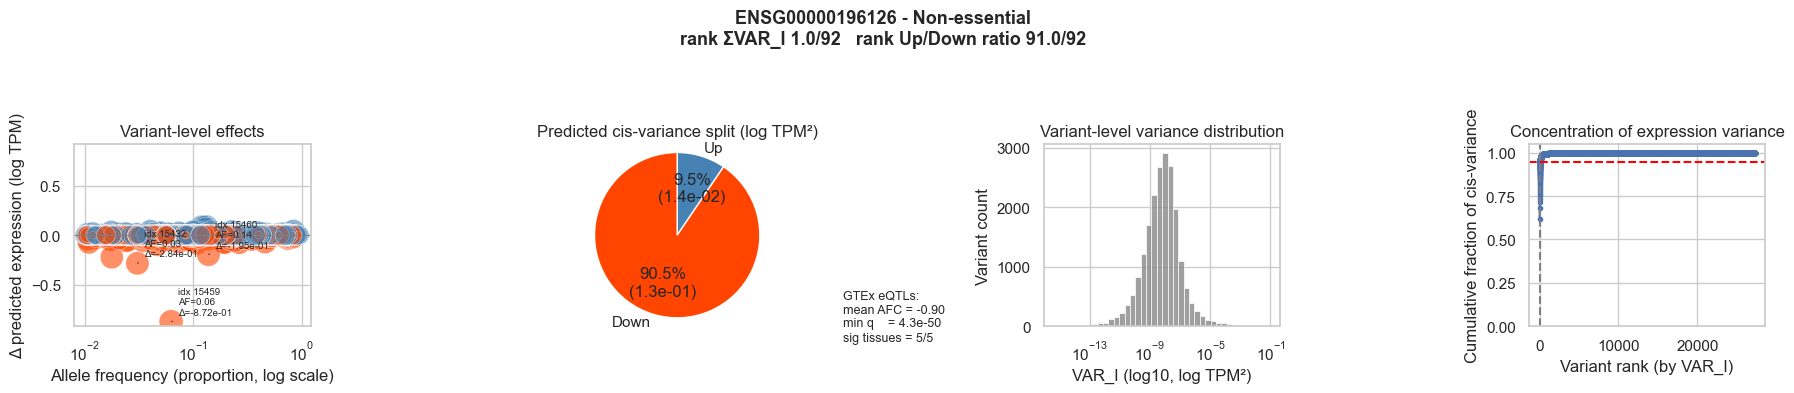

ENSG00000196126  (Non-essential)
variants: 27265   up: 12658   down: 14607
Σ VAR_I up   = 1.37e-02
Σ VAR_I down = 1.31e-01
Up fraction  = 9.49%
rank ΣVAR_I  = 1.0/92
rank Up/Down = 91.0/92
GTEx eQTLs: | mean AFC = -0.90 | min q    = 4.3e-50 | sig tissues = 5/5


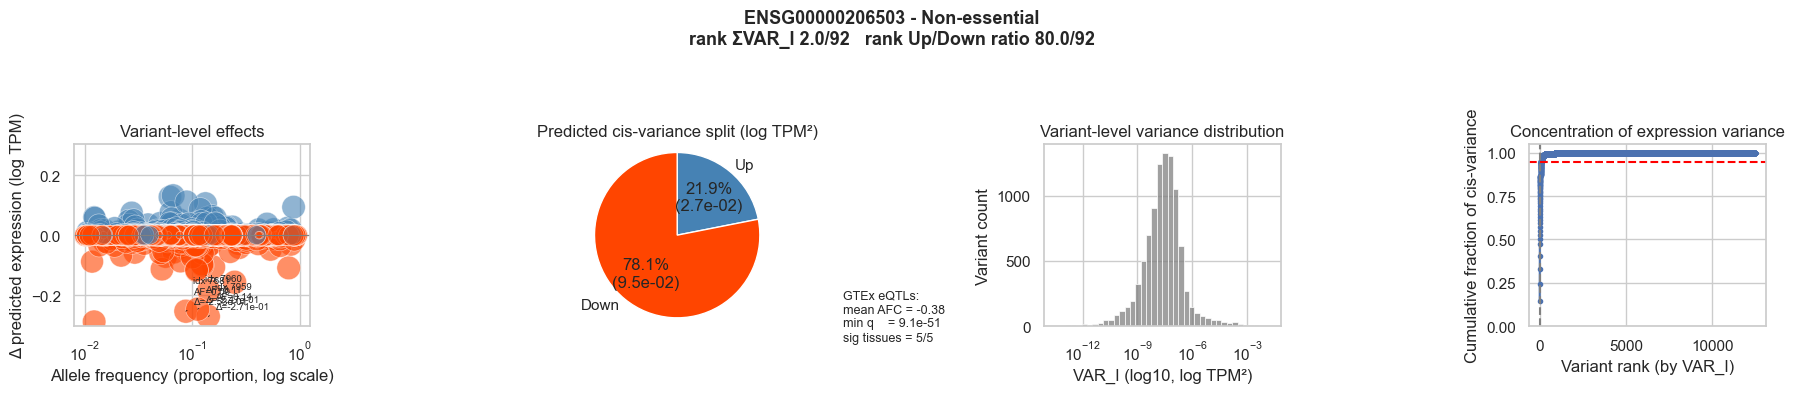

ENSG00000206503  (Non-essential)
variants: 12461   up: 1506   down: 10955
Σ VAR_I up   = 2.68e-02
Σ VAR_I down = 9.55e-02
Up fraction  = 21.91%
rank ΣVAR_I  = 2.0/92
rank Up/Down = 80.0/92
GTEx eQTLs: | mean AFC = -0.38 | min q    = 9.1e-51 | sig tissues = 5/5


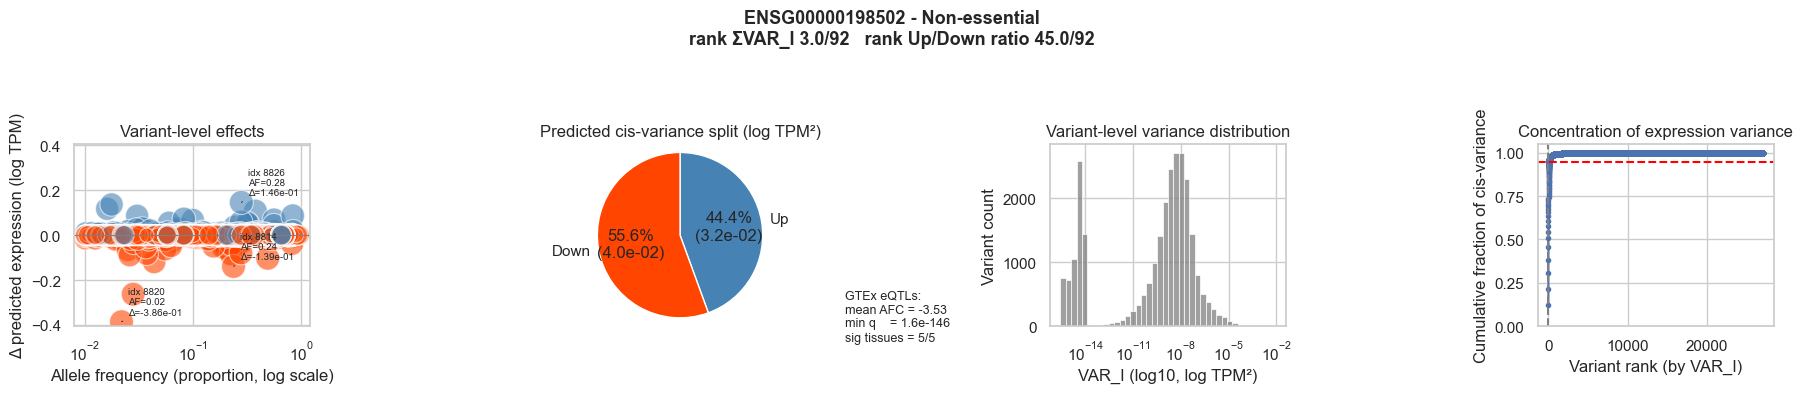

ENSG00000198502  (Non-essential)
variants: 27133   up: 6372   down: 20761
Σ VAR_I up   = 3.18e-02
Σ VAR_I down = 3.98e-02
Up fraction  = 44.44%
rank ΣVAR_I  = 3.0/92
rank Up/Down = 45.0/92
GTEx eQTLs: | mean AFC = -3.53 | min q    = 1.6e-146 | sig tissues = 5/5


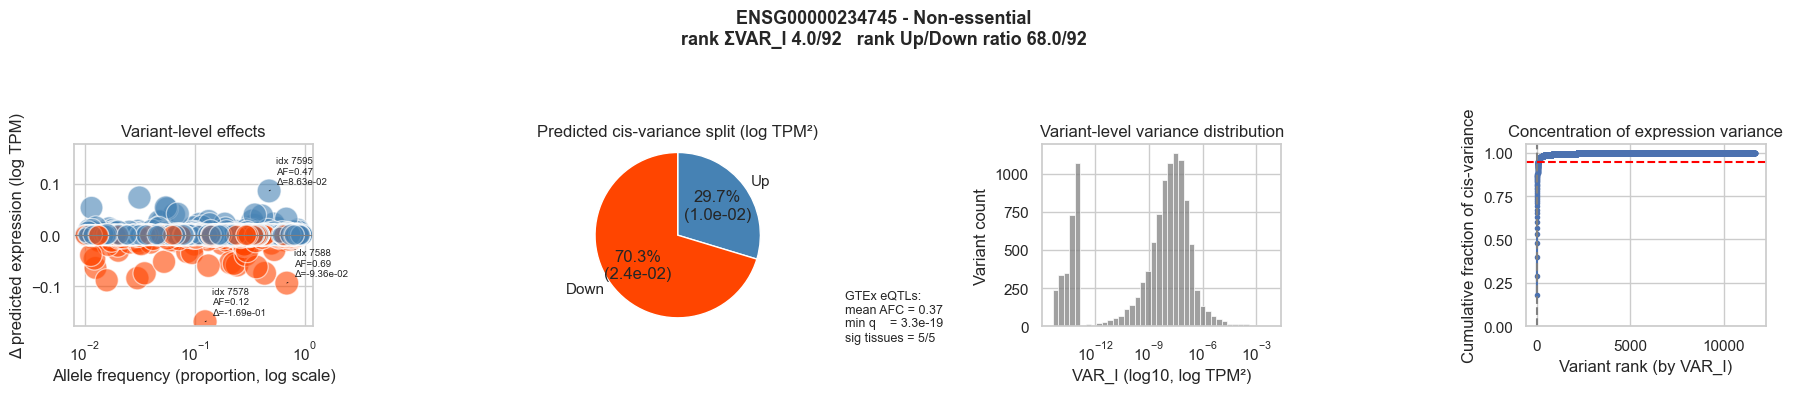

ENSG00000234745  (Non-essential)
variants: 11634   up: 8934   down: 2700
Σ VAR_I up   = 1.02e-02
Σ VAR_I down = 2.41e-02
Up fraction  = 29.68%
rank ΣVAR_I  = 4.0/92
rank Up/Down = 68.0/92
GTEx eQTLs: | mean AFC = 0.37 | min q    = 3.3e-19 | sig tissues = 5/5


In [30]:
top_nonessential = (
    var_df_nonessential
        .sort_values("predicted_cis_variance", ascending=False)
        .head(4)["gene_id"]
)

for g in top_nonessential:
    plot_gene_variants(g, cohort="Non-essential")


Here we have the highest-scoring non-essential genes by total predicted cis-variance

- Some non-essential genes show high total cis-variance — especially ENSG00000196126 and ENSG00000206503 — reaching levels seen in dosage-sensitive ClinGen genes.

- Variance is strongly dominated by down-regulating variants, often >90% of the total signal. This contrasts sharply with top ClinGen genes, where variance was often driven by *up*-regulating effects.

- Several down-regulating variants exhibit very large predicted ∆ values (up to 0.8), which dominate the variance distribution and drive the extreme skew.

- In all cases, a small number of variants explain nearly all predicted variance — indicating potential regulatory hotspots?

Despite being non-essential cohort, these genes still carry large, sharply directional cis-regulatory effects. The prevalence of strong down-regulating variants suggests that some non-essential genes may still be regulatory constraint or could be misclassified

### 1.2.2 The most extreme up–down imbalance

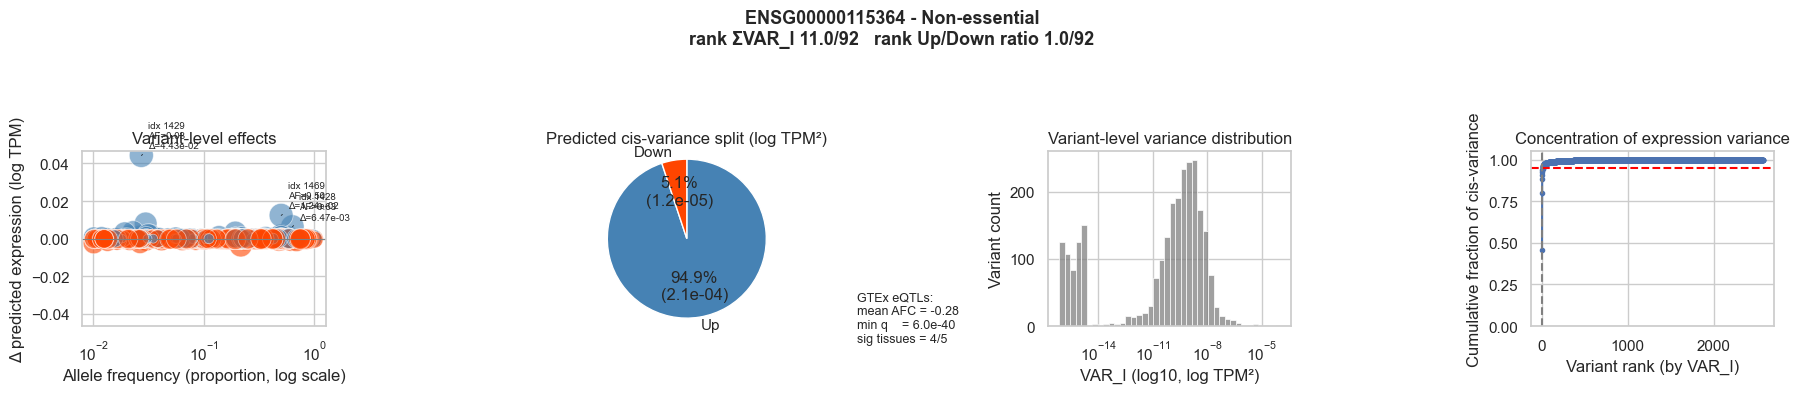

ENSG00000115364  (Non-essential)
variants: 2577   up: 1033   down: 1544
Σ VAR_I up   = 2.14e-04
Σ VAR_I down = 1.15e-05
Up fraction  = 94.91%
rank ΣVAR_I  = 11.0/92
rank Up/Down = 1.0/92
GTEx eQTLs: | mean AFC = -0.28 | min q    = 6.0e-40 | sig tissues = 4/5


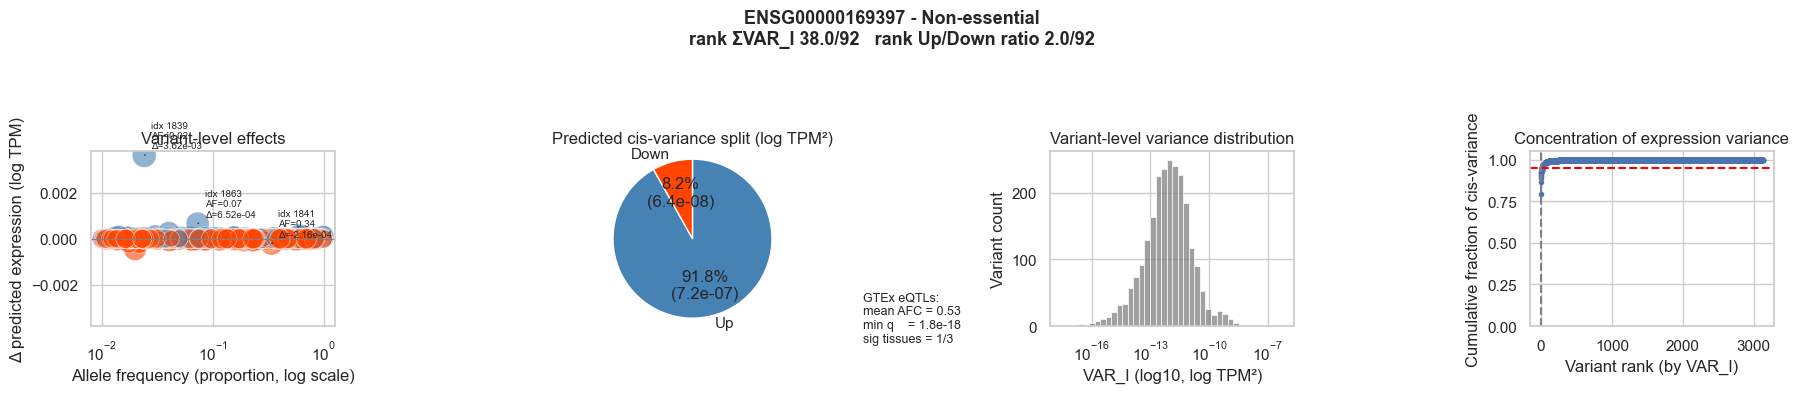

ENSG00000169397  (Non-essential)
variants: 3131   up: 746   down: 2385
Σ VAR_I up   = 7.17e-07
Σ VAR_I down = 6.38e-08
Up fraction  = 91.83%
rank ΣVAR_I  = 38.0/92
rank Up/Down = 2.0/92
GTEx eQTLs: | mean AFC = 0.53 | min q    = 1.8e-18 | sig tissues = 1/3


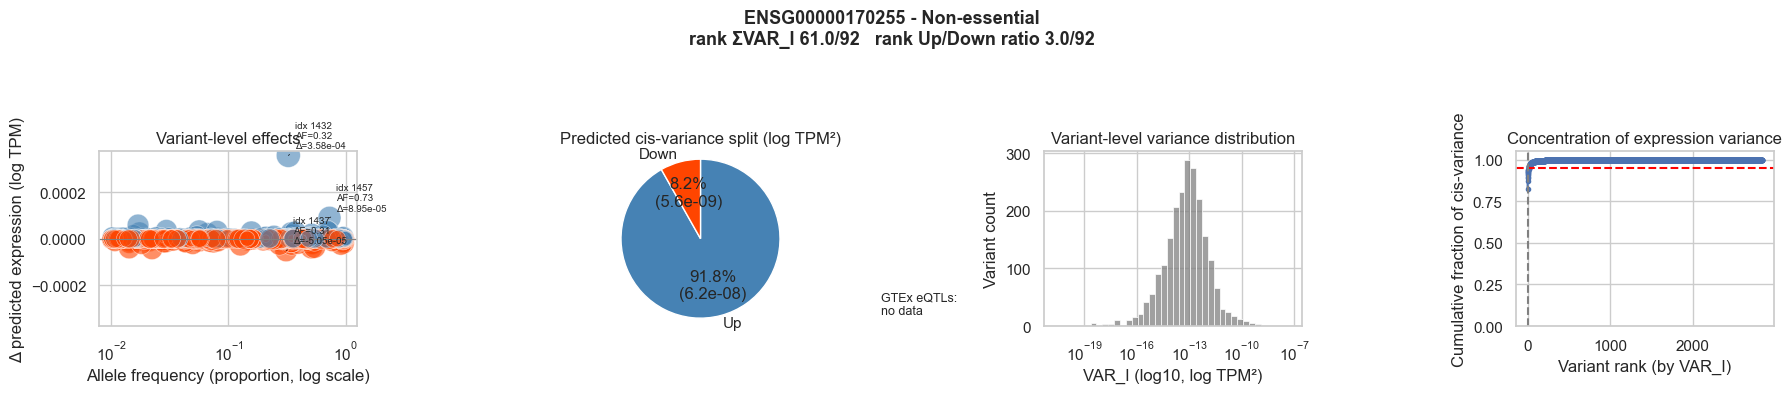

ENSG00000170255  (Non-essential)
variants: 2840   up: 755   down: 2085
Σ VAR_I up   = 6.25e-08
Σ VAR_I down = 5.58e-09
Up fraction  = 91.80%
rank ΣVAR_I  = 61.0/92
rank Up/Down = 3.0/92
GTEx eQTLs: | no data


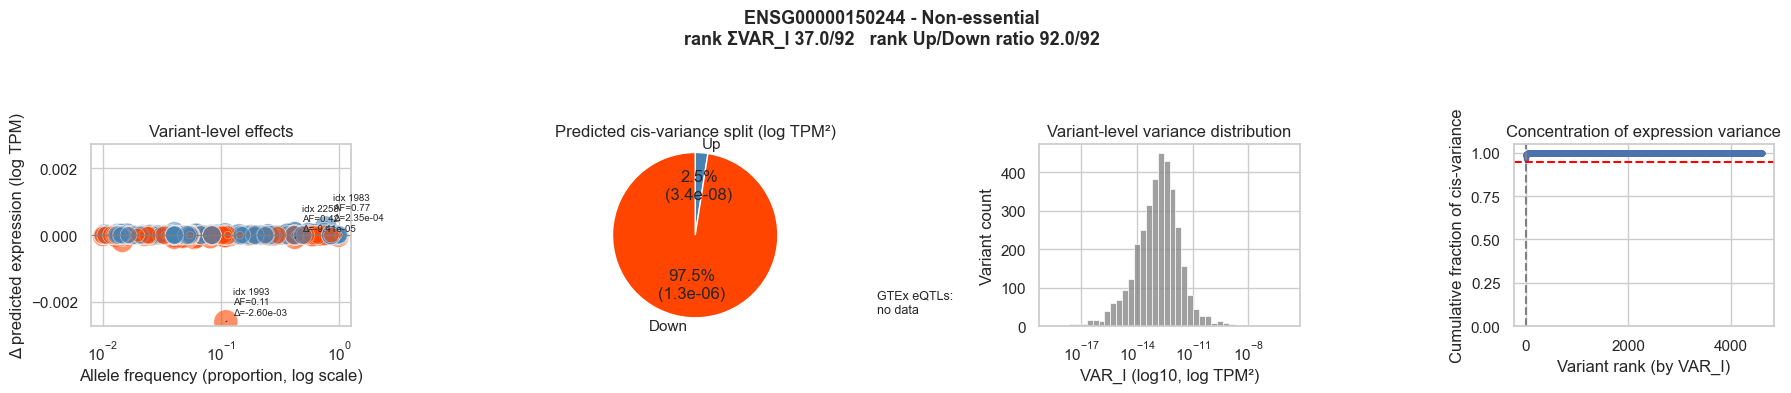

ENSG00000150244  (Non-essential)
variants: 4609   up: 1893   down: 2716
Σ VAR_I up   = 3.38e-08
Σ VAR_I down = 1.34e-06
Up fraction  = 2.46%
rank ΣVAR_I  = 37.0/92
rank Up/Down = 92.0/92
GTEx eQTLs: | no data


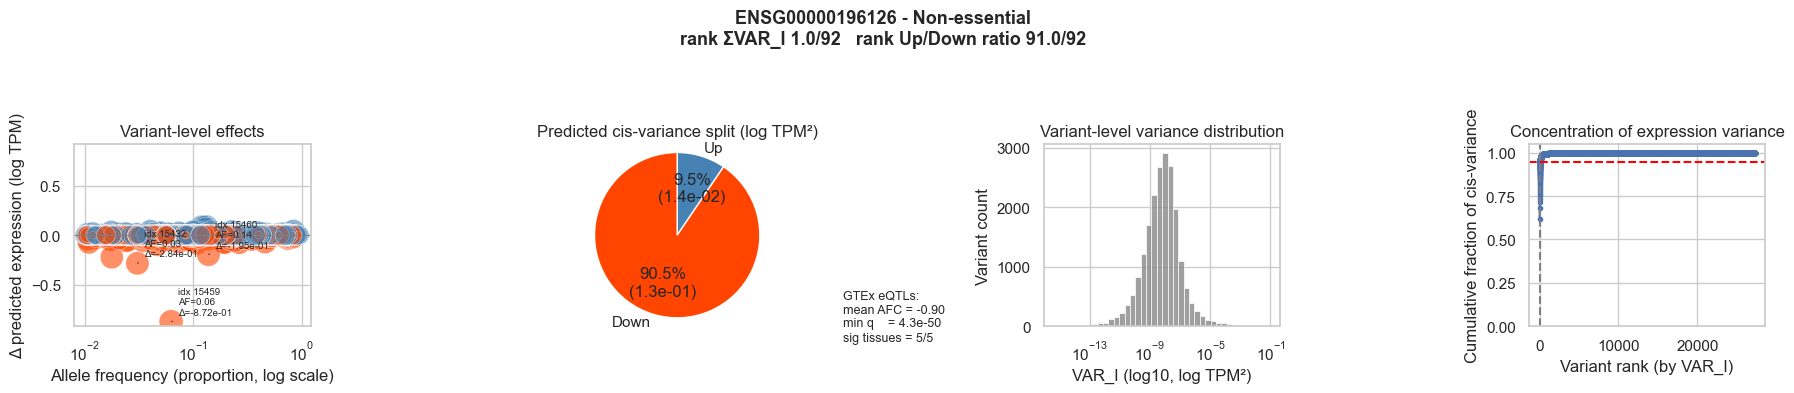

ENSG00000196126  (Non-essential)
variants: 27265   up: 12658   down: 14607
Σ VAR_I up   = 1.37e-02
Σ VAR_I down = 1.31e-01
Up fraction  = 9.49%
rank ΣVAR_I  = 1.0/92
rank Up/Down = 91.0/92
GTEx eQTLs: | mean AFC = -0.90 | min q    = 4.3e-50 | sig tissues = 5/5


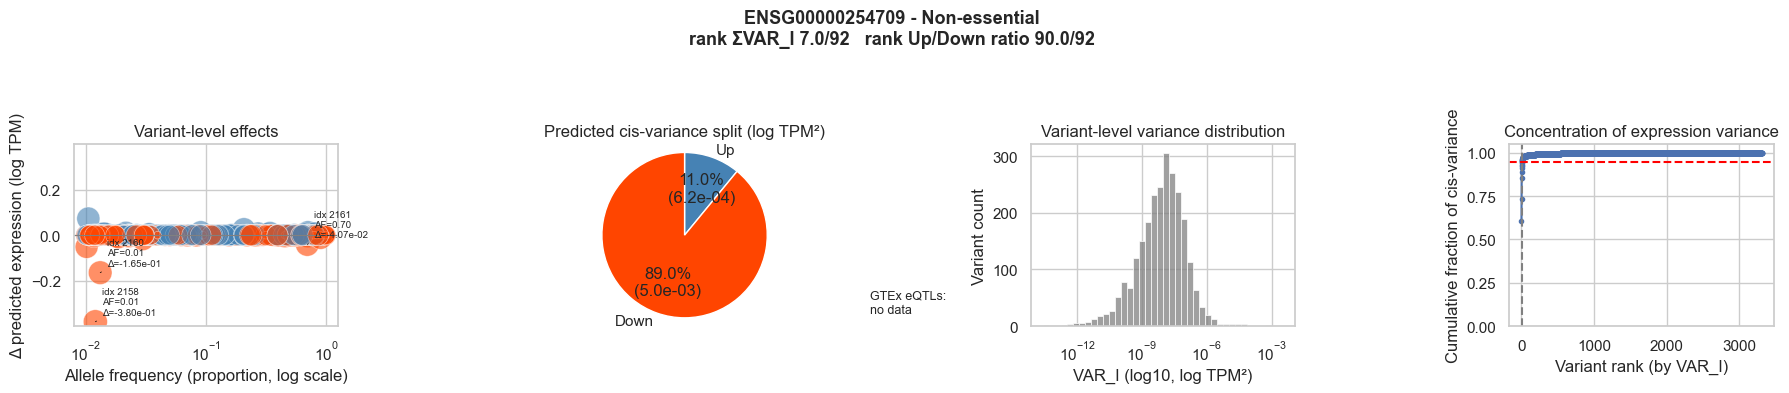

ENSG00000254709  (Non-essential)
variants: 3314   up: 1407   down: 1907
Σ VAR_I up   = 6.21e-04
Σ VAR_I down = 5.04e-03
Up fraction  = 10.95%
rank ΣVAR_I  = 7.0/92
rank Up/Down = 90.0/92
GTEx eQTLs: | no data


In [31]:
extreme_ratio_ne = (
    var_df_nonessential
        .sort_values("up_down_ratio", ascending=False)  # biggest Up/Down ratios
        .head(3)["gene_id"]
)

for g in extreme_ratio_ne:
    plot_gene_variants(g, cohort="Non-essential")

down_skewed_ne = (
    var_df_nonessential
        .sort_values("up_down_ratio", ascending=True)
        .head(3)["gene_id"]
)

for g in down_skewed_ne:
    plot_gene_variants(g, cohort="Non-essential")

Non-essential genes with the strongest directional skew in their predicted cis-variance:

  - Some genes (e.g. ENSG00000115364, ENSG00000169397, ENSG00000170255) show >90% of variance from up-regulating variants.
  - Others (e.g. ENSG00000196126, ENSG00000150244, ENSG00000254709) show the opposite—>90% from down-regulating variants.

- Als the total variance does not always match skew:
  - ENSG00000196126 has very high total variance, dominated by *down* effects (131x stronger than up).
  - ENSG00000115364 has a high *up*-skew but much lower total variance, so may be less biologically impactful.

  - In all genes, the cumulative plots show that a small number of variants account for nearly all the variance, reinforcing the role of regulatory hotspots.

  - Some of these "non-essential" genes carry skew and signal strength more typical of constraint or dosage sensitivity. Maybe they are misclassified?

So up–down imbalance is common and sometimes extreme, but only a few genes (ENSG00000196126, ENSG00000254709) combine this with substantial total variance.

## Summary

Across both cohorts these plots show that expression variance is almost never evenly distributed.

- A single promoter SNP—sometimes two or three—accounts for ≥ 95 % of the predicted dosage fluctuation in nearly every gene.

- For ClinGen genes that variant is usually up-regulating, whereas in the non-essential set we find both strong up- and strong down-regulating alleles.

This suggests that expression control is often bottlenecked at one or two key regulatory sites.

- In ClinGen genes, the skew toward up-regulating variants may reflect buffering against haploinsufficiency.

- In contrast, the non-essential genes show more mixed directionality, with many dominated by strong down-regulating effects—some with surprisingly high total variance.

Overall, these results show that common regulatory variants can have large concentrated effects, and that directional imbalance may hint at functional constraint even in genes labeled non-essential.